<a href="https://colab.research.google.com/github/amiralitalebi/CW_MN3B/blob/main/cnn_model_amirali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive and go to coursework folder
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/coursework_project")
print("Current working directory:", os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/coursework_project


In [ ]:
# STEP 1: Import libraries
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# STEP 2: Load label map and datasets
with open("datasets/processed_part1/label_map.json") as f:
    raw_map = json.load(f)
label_map = {int(k): v for k, v in raw_map.items()}

X_train = np.load("datasets/processed_part1/X_train.npy")
y_train = np.load("datasets/processed_part1/y_train.npy")

X_val   = np.load("datasets/processed_part1/X_val.npy")
y_val   = np.load("datasets/processed_part1/y_val.npy")

X_test  = np.load("datasets/processed_part1/X_test.npy")
y_test  = np.load("datasets/processed_part1/y_test.npy")

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)


Train: (2308, 100, 100, 3) Val: (578, 100, 100, 3) Test: (39767, 100, 100, 3)
Number of classes: 6


In [ ]:
# STEP 3: Reduce large test set (helps with RAM)
X_test = X_test[:5000]
y_test = y_test[:5000]

print("Reduced Test:", X_test.shape)

# Normalise pixel values to 0–1
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")
X_test  = X_test.astype("float32")

X_train /= 255.0
X_val   /= 255.0
X_test  /= 255.0


Reduced Test: (5000, 100, 100, 3)


In [ ]:
# STEP 4: Define simple data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")


In [ ]:
# STEP 5: Build CNN model (Functional API, Grad-CAM friendly)
input_shape = (100, 100, 3)
inputs = keras.Input(shape=input_shape)

x = data_augmentation(inputs)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv1")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="last_conv")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

cnn_model = keras.Model(inputs=inputs, outputs=outputs, name="fruit_cnn")

cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()


Model: "fruit_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453,446 (9.36 MB)

 Trainable params: 2,453,446 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# STEP 6: Train CNN
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 851ms/step - accuracy: 0.2282 - loss: 1.7402 - val_accuracy: 0.2093 - val_loss: 1.7012
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.2406 - loss: 1.7178 - val_accuracy: 0.2093 - val_loss: 1.7009
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 905ms/step - accuracy: 0.2481 - loss: 1.7001 - val_accuracy: 0.2093 - val_loss: 1.6998
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 64s 867ms/step - accuracy: 0.2462 - loss: 1.7040 - val_accuracy: 0.2093 - val_loss: 1.7002
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 62s 845ms/step - accuracy: 0.2459 - loss: 1.6885 - val_accuracy: 0.2595 - val_loss: 1.6990
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 85s 885ms/step - accuracy: 0.2211 - loss: 1.7186 - val_accuracy: 0.2093 - val_loss: 1.6978
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 80s 858ms/step - accuracy: 0.2470 - loss: 1.7228 - val_accuracy: 0.2093 - val_loss: 1.6966
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 82s 863ms/step - accuracy: 0.2556 - loss: 1.7225 - val_accu

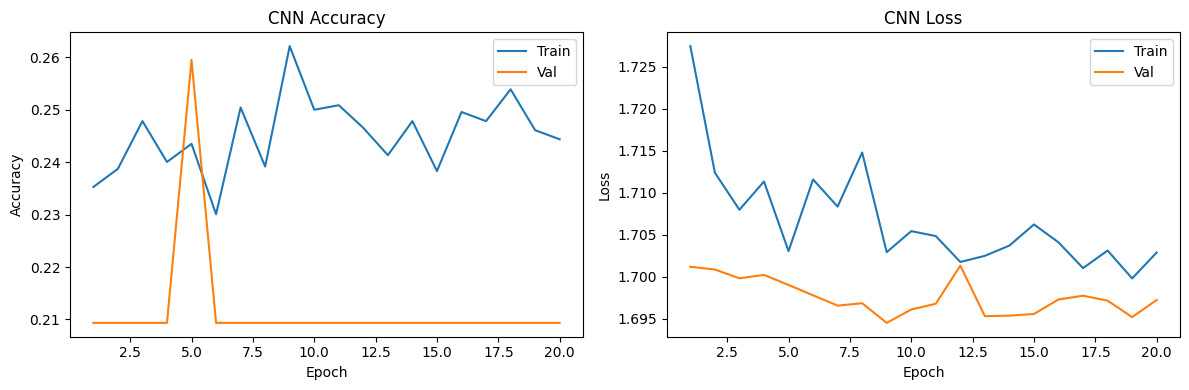

In [ ]:
# STEP 7: Plot CNN training/validation accuracy and loss
def plot_history(history, title_prefix=""):
    hist = history.history
    epochs = range(1, len(hist["accuracy"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["accuracy"], label="Train")
    plt.plot(epochs, hist["val_accuracy"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["loss"], label="Train")
    plt.plot(epochs, hist["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(cnn_history, "CNN")


79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 554ms/step
CNN Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       231
           1       0.00      0.00      0.00       142
           2       0.00      0.00      0.00       154
           3       0.05      1.00      0.09       235
           4       0.00      0.00      0.00       154
           5       0.00      0.00      0.00       201
           6       0.00      0.00      0.00       160
           7       0.00      0.00      0.00       241
           8       0.00      0.00      0.00       146
           9       0.00      0.00      0.00       157
          10       0.00      0.00      0.00       229
          11       0.00      0.00      0.00       228
          12       0.00      0.00      0.00       231
          13       0.00      0.00      0.00       164
          14       0.00      0.00      0.00       156
          15       0.00      0.00      0.00       148
          1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x800 with 0 Axes>

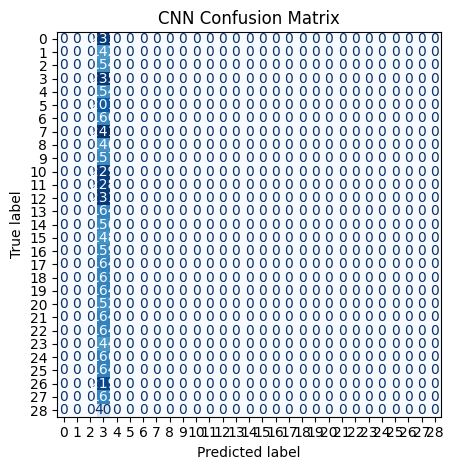

In [ ]:
# STEP 8: CNN classification report and confusion matrix
cnn_test_probs = cnn_model.predict(X_test, batch_size=64)
cnn_y_pred = np.argmax(cnn_test_probs, axis=1)

print("CNN Classification Report:\n")
print(classification_report(y_test, cnn_y_pred))

cm_cnn = confusion_matrix(y_test, cnn_y_pred)

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn)
disp.plot(cmap="Blues", colorbar=False)
plt.title("CNN Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# STEP 9: Grad-CAM heatmap function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Build a model that maps the input image to:
    # (1) the activations of the last conv layer
    # (2) the final predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of the target class w.r.t. conv layer outputs
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients over each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


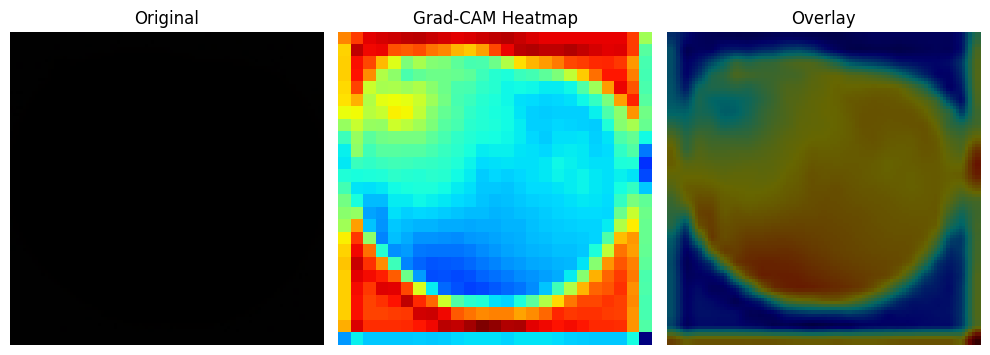

True label: Apple 10
Predicted label: Apple 13


In [ ]:
# STEP 10: Show Grad-CAM for one test image
import cv2

idx = 0  # you can change this index
img = X_test[idx]          # already normalised
img_array = np.expand_dims(img, axis=0)

# Build heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    cnn_model,
    last_conv_layer_name="last_conv"
)

# Resize heatmap to image size
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Prepare original image for display (convert back to 0–255)
img_disp = (img * 255).astype("uint8")
superimposed_img = cv2.addWeighted(img_disp, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_disp)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

true_label = label_map[int(y_test[idx])]
pred_label = label_map[int(cnn_y_pred[idx])]
print("True label:", true_label)
print("Predicted label:", pred_label)
